In [1]:
from __future__ import print_function
from __future__ import division

import time
import copy
import os
import urllib
import gc
import datetime
import warnings
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.optim as optim
import torch.onnx
import torchvision
from torchvision import models, transforms

import cv2


from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
#!conda install scipy==1.2.0

In [3]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0
Torchvision Version:  0.7.0


In [4]:
pretrained = models.inception_v3(init_weights=False)

In [1]:
#pretrained

In [6]:
pretrained_weights = torch.load('../input/torchvision-inception-v3-imagenet-pretrained/inception_v3_google-1a9a5a14.pth', map_location='cpu')
#pretrained_weights

In [7]:
pretrained.load_state_dict(pretrained_weights)

<All keys matched successfully>

In [8]:
pretrained.__class__

torchvision.models.inception.Inception3

In [9]:
train = pd.read_csv('/kaggle/input/jpeg-melanoma-256x256/train.csv')
#train.head()

In [10]:
train = train.dropna(axis=0)
#train.info()

In [11]:
test = pd.read_csv('/kaggle/input/jpeg-melanoma-256x256/test.csv')
#test.head()

In [12]:
test = test.dropna(axis=0)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10631 entries, 1 to 10981
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10631 non-null  object 
 1   patient_id                     10631 non-null  object 
 2   sex                            10631 non-null  object 
 3   age_approx                     10631 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
 5   width                          10631 non-null  int64  
 6   height                         10631 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 664.4+ KB


In [13]:
path_train = '../input/jpeg-melanoma-256x256/train/'
path_test = '../input/jpeg-melanoma-256x256/test/'

In [14]:
dir_train = os.listdir(path_train)
dir_test = os.listdir(path_test)

In [15]:
def add_jpg(nombre):
    nombre = nombre + '.jpg'
    return nombre

In [16]:
def buscar_imagen(path, nombre):
    if add_jpg(nombre) in directorio:
        image = np.array(path + nombre)
    return image

In [17]:
for nombre_imagen in train['image_name']:
    if add_jpg(nombre_imagen) not in dir_train:
        os.remove(path_train + add_jpg(nombre_imagen))
print('listo')
for nombre_imagen in test['image_name']:
    if add_jpg(nombre_imagen) not in dir_test:
        os.remove(path_test + add_jpg(nombre_imagen))

listo


In [18]:
class Data(Dataset):
    def __init__(self, df: pd.DataFrame, path: str, train: bool = True, preprocesar = None, context = None):
        self.preprocesar = preprocesar
        self.df = df
        self.path = path
        self.train = train
        self.context = context
        
    def __getitem__(self, index):
        im_path = os.path.join(self.path, self.df.iloc[index]['image_name'] + '.jpg')
        x = cv2.imread(im_path)
        meta = np.array(self.df.iloc[index][self.context].values, dtype=np.float32)

        if self.preprocesar:
            x = self.preprocesar(x)
            
        if self.train:
            y = self.df.iloc[index]['target']
            return (x, meta), y
        else:
            return (x, meta)
    
    def __len__(self):
        return len(self.df)

In [19]:
class Red_Neuronal(nn.Module):
    def __init__(self, pretrained, n_meta_features: int):
        super(Red_Neuronal, self).__init__()
        self.pretrained = pretrained
        if 'Inception3' in str(pretrained.__class__):
            self.pretrained.AuxLogits.fc = nn.Linear(in_features = 768, out_features = 1)
            self.pretrained.fc = nn.Linear(in_features = 2048, out_features = 512, bias = True)
        #if 'ResNet' in str(pretrained.__class__):
         #   self.pretrained.fc = nn.Linear(in_features=512, out_features=1, bias=True)
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 512),
                                  nn.BatchNorm1d(512),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.25),
                                  nn.Linear(512, 256),
                                  nn.BatchNorm1d(256),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.output = nn.Linear(512 + 256, 1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
              
        
        x, meta = inputs
        cnn_features = self.pretrained(x)
        context = self.meta(meta)
        features = torch.cat((cnn_features, context), dim=1)
        output = self.ouput(features)
        return output

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [22]:
# beningo = 0; maligno = 1
train = train.rename(columns = {'anatom_site_general_challenge':'localizacion', 'age_approx':'edad', 'sex':'sexo'})
train = train[train.columns[:-3]]
train.drop(labels = ['benign_malignant', 'diagnosis'], axis=1, inplace = True)
train

,image_name,patient_id,sexo,edad,localizacion,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,0
...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,0


In [23]:
train['target'].sum()

575

In [24]:
test = test.rename(columns = {'anatom_site_general_challenge':'localizacion', 'age_approx':'edad', 'sex':'sexo'})
test = test[test.columns[:-2]]
test

,image_name,patient_id,sexo,edad,localizacion
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity
5,ISIC_0074618,IP_4438996,male,50.0,lower extremity
...,...,...,...,...,...
10977,ISIC_9992485,IP_4152479,male,40.0,torso
10978,ISIC_9996992,IP_4890115,male,35.0,torso
10979,ISIC_9997917,IP_2852390,male,25.0,upper extremity
10980,ISIC_9998234,IP_8861963,male,65.0,lower extremity


In [25]:
loc_dummies_train = pd.get_dummies(train['localizacion'],dummy_na=False, dtype=np.uint8, prefix='site')

In [26]:
print(train.shape)

(32531, 6)


In [27]:
loc_dummies_train.iloc[:train.shape[0]]

,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_torso,site_upper extremity
0,1,0,0,0,0,0
1,0,0,0,0,0,1
2,0,1,0,0,0,0
3,1,0,0,0,0,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
33121,0,0,0,0,1,0
33122,0,0,0,0,1,0
33123,0,1,0,0,0,0
33124,0,1,0,0,0,0


In [28]:
train = pd.concat([train, loc_dummies_train.iloc[:train.shape[0]]], axis=1)
train.drop(labels = ['localizacion'], axis=1, inplace = True)

In [29]:
train = train[['image_name', 'patient_id', 'sexo', 'edad', 
              'site_head/neck','site_lower extremity', 'site_oral/genital', 
               'site_palms/soles','site_torso', 'site_upper extremity', 'target']]
train.head()

,image_name,patient_id,sexo,edad,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_torso,site_upper extremity,target
0,ISIC_2637011,IP_7279968,male,45.0,1,0,0,0,0,0,0
1,ISIC_0015719,IP_3075186,female,45.0,0,0,0,0,0,1,0
2,ISIC_0052212,IP_2842074,female,50.0,0,1,0,0,0,0,0
3,ISIC_0068279,IP_6890425,female,45.0,1,0,0,0,0,0,0
4,ISIC_0074268,IP_8723313,female,55.0,0,0,0,0,0,1,0


In [30]:
train = train[train['edad'] > 10.0]
train[train['edad'] < 15.0]

,image_name,patient_id,sexo,edad,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_torso,site_upper extremity,target


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a190cae10>]],
      dtype=object)

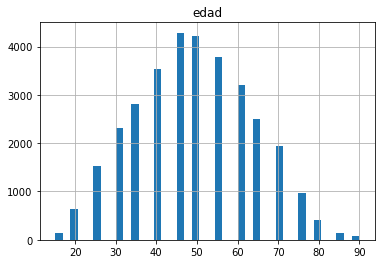

In [31]:
train.hist(column = 'edad', bins = 40)

In [32]:
loc_dummies_test = pd.get_dummies(test['localizacion'],dummy_na=True, dtype=np.uint8, prefix='site')
test = pd.concat([test, loc_dummies_test.iloc[:test.shape[0]]], axis=1)
test.drop(labels = ['localizacion'], axis=1, inplace = True)

In [33]:
train['sexo'] = train['sexo'].map({'male': 1, 'female': 0})
test['sexo'] = test['sexo'].map({'male': 1, 'female': 0})

In [34]:
# escalar variable numérica por el método min_max

edad_max = train['edad'].max()
edad_min = train['edad'].min()


edad_max


90.0

In [35]:
edad_max_test = test['edad'].max()
edad_min_test = test['edad'].min()

rango_edad = (edad_max - edad_min)
rango_edad_test = (edad_max_test - edad_min_test)

rango_edad

75.0

In [36]:
train['edad'] = (train['edad'] - edad_min) / rango_edad
test['edad'] = (test['edad'] - edad_min_test) / rango_edad_test

In [37]:
context = ['sexo', 'edad'] + [col for col in train.columns if 'site_' in col]
context

['sexo',
 'edad',
 'site_head/neck',
 'site_lower extremity',
 'site_oral/genital',
 'site_palms/soles',
 'site_torso',
 'site_upper extremity']

In [38]:
preprocesar = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [39]:
epochs = 20
paciencia = 3

oof = np.zeros((len(train), 1))  # Out Of Fold predictions
preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)  # Predictions for test test

#kf = GroupKFold(n_splits=4)
kf = KFold(n_splits=4, shuffle=True, random_state=47)


In [40]:
#(n, b) = enumerate(kf.get_n_splits(X=np.zeros(len(train), dtype=np.int), y=train['target'], groups=train['patient_id'].tolist()), 1)
#print(n)


In [41]:
for fold, (id_train, id_val) in enumerate(kf.split(X=np.zeros(len(train)), y=train['target']), 1):
    print (fold, id_train, id_val)
    

1 [    0     1     2 ... 32506 32509 32511] [    4     7     9 ... 32507 32508 32510]
2 [    1     2     3 ... 32509 32510 32511] [    0    13    17 ... 32503 32504 32506]
3 [    0     1     3 ... 32509 32510 32511] [    2     6    10 ... 32485 32489 32505]
4 [    0     2     4 ... 32507 32508 32510] [    1     3     5 ... 32501 32509 32511]


In [42]:
test_data = Data(df=test,
                       path = '../input/jpeg-melanoma-256x256/test', 
                       train=False,
                       preprocesar=preprocesar,
                       context=context)

In [43]:
for fold, (id_train, id_val) in enumerate(kf.split(X=np.zeros(len(train)), y=train['target']), 1):
    print('=' * 20, 'Fold', fold, '=' * 20) 
    model_path = f'model_{fold}.pth'  # Path and filename to save model to
    best_val = 0  # Best validation score within this fold
    model = Red_Neuronal(pretrained=pretrained, n_meta_features=len(context))
    model = model.to(device)
    
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
    criterion = nn.BCEWithLogitsLoss()
    
    train_data = Data(df=train.iloc[id_train].reset_index(drop=True), 
                            path='../input/jpeg-melanoma-256x256/train/', 
                            train=True, 
                            preprocesar=preprocesar,
                            context=context)
    val = Data(df=train.iloc[id_val].reset_index(drop=True), 
                            path='../input/jpeg-melanoma-256x256/train/', 
                            train=True, 
                            preprocesar=preprocesar,
                            context=context)
    
    train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(dataset=test_data, batch_size=16, shuffle=False, num_workers=2)
    
        
    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        epoch_loss = 0
        model.train()
        
        for x, y in train_loader:
            x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
            x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            optim.zero_grad()
            z, aux = model(x)
            
            outputs, aux_outputs = model(inputs)
            loss1 = criterion(z, y.unsqueeze(1))
            loss2 = criterion(aux, y.unsqueeze(1))
            loss = loss1 + 0.4*loss2
            loss.backward()
            optim.step()
            pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
            correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
            epoch_loss += loss.item()
        train_acc = correct / len(id_train)
        
        model.eval()  # switch model to the evaluation mode
        val_preds = torch.zeros((len(id_val), 1), dtype=torch.float32, device=device)
        with torch.no_grad():  # Do not calculate gradient since we are only predicting
            # Predicting on validation set
            for j, (x_val, y_val) in enumerate(val_loader):
                x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
                x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
                y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                z_val = model(x_val)
                val_pred = torch.sigmoid(z_val)
                val_preds[j*val_loader.batch_size:j*val_loader.batch_size + x_val[0].shape[0]] = val_pred
            val_acc = accuracy_score(train.iloc[id_val]['target'].values, torch.round(val_preds.cpu()))
            val_roc = roc_auc_score(train.iloc[id_val]['target'].values, val_preds.cpu())
            
            print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
            epoch + 1, 
            epoch_loss, 
            train_acc, 
            val_acc, 
            val_roc, 
            str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
            
            scheduler.step(val_roc)
                
            if val_roc >= best_val:
                best_val = val_roc
                patience = es_patience  # Resetting patience since we have new best validation accuracy
                torch.save(model, model_path)  # Saving current best model
            else:
                patience -= 1
                if patience == 0:
                    print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                    break
                
    model = torch.load(model_path)  # Loading best model of this fold
    model.eval()  # switch model to the evaluation mode
    val_preds = torch.zeros((len(id_val), 1), dtype=torch.float32, device=device)
    with torch.no_grad():
        # Predicting on validation set once again to obtain data for OOF
        for j, (x_val, y_val) in enumerate(val_loader):
            x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
            x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
            y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
            z_val = model(x_val)
            val_pred = torch.sigmoid(z_val)
            val_preds[j*val_loader.batch_size:j*val_loader.batch_size + x_val[0].shape[0]] = val_pred
        oof[id_val] = val_preds.cpu().numpy()
        
        # Predicting on test set
        tta_preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)
        for _ in range(TTA):
            for i, x_test in enumerate(test_loader):
                x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
                x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
                z_test = model(x_test)
                z_test = torch.sigmoid(z_test)
                tta_preds[i*test_loader.batch_size:i*test_loader.batch_size + x_test[0].shape[0]] += z_test
        preds += tta_preds / TTA
    
preds /= kf.n_split

==================== Fold 1 ====================


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


TypeError: expected Tensor as element 0 in argument 0, but got InceptionOutputs

In [44]:
print('OOF: {:.3f}'.format(roc_auc_score(train_df['target'], oof)))

NameError: name 'train_df' is not defined

In [45]:
sns.kdeplot(pd.Series(preds.cpu().numpy().reshape(-1,)));

NameError: name 'sns' is not defined

In [46]:
# Saving OOF predictions so stacking would be easier
pd.Series(oof.reshape(-1,)).to_csv('oof.csv', index=False)

In [47]:
sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
sub['target'] = preds.cpu().numpy().reshape(-1,)
sub.to_csv('submission.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv'